### Index Long side strategy
- Time Frame: Daily
- RSI(7) - 7 periods
- SMA(8) & SMA(20)
- MACD(12,26,9)


#### Strategy Overview
- SMA, MACD are lagging trend indicators that help to identify the direction of the trend
- RSI is a leading momentum indicators that assesses general strength trend
- This strategy uses RSI as an early signal and SMA and MACD as a confirmation
- Bullish crossover happens when SMA8 > SMA20 and indicates upward trend
- We apply same time frame for both leading and lagging indicators (daily).

#### Entry Condition:

Signal: 
- If RSI(7) > 50
- Wait for x candles for either trend conditions to become true (confirmation)

Confirmation:
1. SMA(8) > SMA(20) (Bullish crossover) -> Long
2. MACD line crosses over the signal line (Uptrend) -> Long


#### Exit Conditions:

x = 5\
If SMA or MACD bullish cross up happens within x days, we will hold on to our positions. 


Exit condition 1:
- If SMA cross up or MACD do not happen within x days, we exit.

Exit Condition 2:
- If SMA cross up or MACD happens within x days, then hold position til either SMA cross down or MACD cross down (MACD histogram > 0)
- 4-5 years historical data

In [ ]:
import os
# print(os.getcwd())
cwd = os.chdir(f"{os.getcwd()}/../") 
print(os.getcwd())

In [ ]:
import pandas as pd
import numpy as np
import pytz
import os
from datetime import datetime as dtt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from data.data_utils import dl_ticker_hist
from src.backtester.strategies import sma_macd_rsi
from src.backtester.plot import plot_sma
from src.backtester.plot import plot_macd
from src.backtester.plot import plot_rsi
from src.backtester.plot import plot_equity_curve
from src.backtester.portfolio import generate_portfolio
from src.metrics.performance import calc_metrics
from src.metrics.performance import get_all_metrics_by_strategy
from src.metrics.trade import calc_trades, calc_trades_metrics, get_recent_trades



In [ ]:
start = "2022-01-01"
end = "2026-01-29"
ticker = 'SPY'

In [ ]:
hist_data = dl_ticker_hist(ticker, start, end)

In [ ]:
FAST_SMA_PERIOD = 8
SLOW_SMA_PERIOD = 20
FAST_MACD_PERIOD = 12
SLOW_MACD_PERIOD = 26
MACD_SIGNAL_PERIOD = 9
RSI_PERIOD = 7

df = sma_macd_rsi(hist_data, sma_fast_period=FAST_SMA_PERIOD, sma_slow_period=SLOW_SMA_PERIOD, macd_fast_period=FAST_MACD_PERIOD, macd_slow_period=SLOW_MACD_PERIOD, macd_signal_period=MACD_SIGNAL_PERIOD, rsi_period=RSI_PERIOD)

In [ ]:
display(df)

In [ ]:
df.info()
df.dtypes

### Plot indicators

In [ ]:
plot_sma(df, ticker, FAST_SMA_PERIOD, SLOW_SMA_PERIOD)

In [ ]:
macd_df = df[['macd','macd_signal','macd_histogram']]
plot_macd(macd_df, ticker)

- When MACD line > signal line, histogram is positive
    - Shows bullish momentum and indicates potential long signal

In [ ]:
plot_rsi(df, ticker, RSI_PERIOD)

In [ ]:
display(df)

## Backtest Strategy
#### Market-On-Close Execution
- Execute trade at or as close as possible to the official closing price of a trading day
- Signal at today's close -> trade executed at today's close -> PnL starts tomorrow


In [ ]:
# Backtest strategy
initial_capital = 100000
allocation = 0.5 # 50% of capital
cost_per_shr = 0.005 # USD per share. Sometimes its cost_per_trade but assumption here is cost per share


In [ ]:
display(df[(df['long_entry']==True) ]) #| (df['long_exit']==True)
# display(df[(df['position']==1)])

In [ ]:
# Generate portfolio positions, trades, pnl, returns
df = generate_portfolio(df, allocation, initial_capital, cost_per_shr)

In [ ]:
display(df[['date', 'long_entry', 'long_exit', 'holding', 'position', 'position_shrs']])
display(df[df['trade']!=''][['date', 'long_entry', 'long_exit', 'holding', 'position', 'position_shrs','trade']])

In [ ]:
display(df[df['trade']!=''])
display(df)

In [ ]:
exit_df = df.copy()
exit_df = exit_df[exit_df['long_exit']==True]
display(exit_df[['date', 'ticker', 'close_px', 'rsi_long_signal', 'sma_cross_long', 'macd_cross_long', 'long_exit']])

In [ ]:
date_str = dtt.now(pytz.timezone('America/New_York')).strftime('%Y_%m_%d')
strategy_id = f'sma_macd_rsi_{date_str}'


### Metrics

In [ ]:
# Metrics
metrics_df = calc_metrics(df, ticker, strategy_id)
display(metrics_df)

In [ ]:

metrics_dir = f'results/metrics/{strategy_id}'
if metrics_dir is not None:
    os.makedirs(metrics_dir, exist_ok=True)
trades_df = calc_trades(df)
trade_metrics_df = calc_trades_metrics(df, ticker, strategy_id, metrics_dir)
recent_trades_df = get_recent_trades(trades_df, ticker, strategy_id, metrics_dir)


In [ ]:
display(trade_metrics_df)

In [ ]:
display(recent_trades_df)

In [ ]:
metrics_df = pd.concat([metrics_df, trade_metrics_df], axis=1)
display(metrics_df)
metrics_df.to_csv(f'{metrics_dir}/metrics_{strategy_id}_{ticker.lower().replace("-","_")}.csv', index=False)


#### Cumulative PnL / Equity Curve

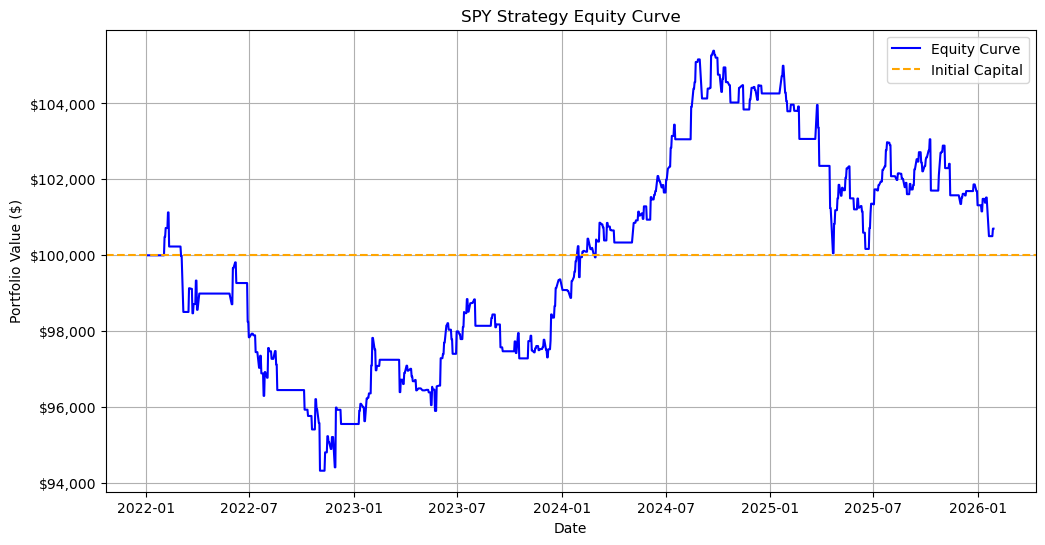

<Figure size 640x480 with 0 Axes>

In [26]:
plot_equity_curve(df, ticker, initial_capital)

### All metrics across different tickers

In [ ]:
all_metrics_df = get_all_metrics_by_strategy(strategy_id)
display(all_metrics_df)

- Sharpe ratio 1+ decent, 1.5 very good. 2+ excellent
- Max drawdown 20-40%
- Win rate 40-60%
- Avg pnl per trade > 0

